In [2]:
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import os
rootdir = os.path.abspath("..")

In [4]:
def read_uuid(rootdir, cancer_type, uuid):
    try:
        return (
            pd
            .read_csv(os.path.join(rootdir, "data", cancer_type, uuid, 
                                    next(filter( lambda s : s.endswith("tsv"),os.listdir(os.path.join(rootdir, "data", cancer_type, uuid)) ))
                                   ),  sep="\t", skiprows=[0,2,3,4,5])
            [['gene_name', "gene_type", 'unstranded', 'stranded_first', 'stranded_second', 'tpm_unstranded','fpkm_unstranded','fpkm_uq_unstranded']]
            .assign(uuid = uuid, cancer_type = cancer_type)
        )
    except Exception as e:
        print(f"Exception occured for {uuid}\n{e}")

In [5]:
df_list = []
for cancer_type in ['bladder', 'skin']:
    uuids = os.listdir(os.path.join(rootdir, "data", cancer_type))
    df = pd.concat([read_uuid(rootdir, cancer_type, uuid) for uuid in tqdm(uuids)])
    df_pivot = (
        df
        .query(f"gene_type=='transcribed_processed_pseudogene'")
        .pivot_table(index=['cancer_type','uuid'], columns = 'gene_name', 
                     values=['unstranded','stranded_first','stranded_second','tpm_unstranded','fpkm_unstranded','fpkm_uq_unstranded'])
    )
    df_pivot = df_pivot.reset_index()
    df_list.append(df_pivot)

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

In [7]:
data = pd.concat(df_list)

In [8]:
data

cancer_type                                  uuid fpkm_unstranded  \
gene_name                                                           ABCA11P   
0             bladder  0180b8ef-dbca-4edd-bce1-3f793f354f13          0.1804   
1             bladder  01d381c7-6398-47cb-925c-078cd538852f          0.3439   
2             bladder  0240ae8f-9354-4123-b791-5333317ae9f0          0.8317   
3             bladder  047dc5b6-c15e-4dad-b753-de55ca6e171c          0.0970   
4             bladder  048da4d7-cab0-49c5-8bc9-78b1bf0b365b          0.3345   
..                ...                                   ...             ...   
468              skin  fe6f0138-1707-4c1c-980f-4711f7c04dec          0.4990   
469              skin  fea970e9-b09c-439c-9b4c-da5f5331643a          0.1615   
470              skin  ff327399-14e8-4926-a7f9-27318dc5dd76          0.3972   
471              skin  ffbf537e-4ff7-42dc-aa8a-386caed2d422          0.6178   
472              skin  ffcf6ae1-5491-43cb-9b66-54addaa56362          0.0077   

                                                                             \
gene_name AC002519.2 AC004057.1 AC004801.2 AC005154.2 AC005230.1 AC005363.1   
0             0.0000     0.2527     0.7431     0.1084        0.0        0.0   
1             0.0387     0.0000     0.2173     0.2228        0.0        0.0   
2             0.0000     0.0524     1.2718     0.5615        0.0        0.0   
3             0.0000     0.1630     0.7296     0.0972        0.0        0.0   
4             0.0000     0.1249     1.1182     0.0893        0.0        0.0   
..               ...        ...        ...        ...        ...        ...   
468           0.0000     0.0000     1.1630     0.2855        0.0        0.0   
469           0.0458     0.1676     2.3140     0.8867        0.0        0.0   
470           0.0963     0.0627     1.3023     0.7955        0.0        0.0   
471           0.0000     0.0911     1.5721     0.8629        0.0        0.0   
472           0.0146     0.1287     0.0822     0.0613        0.0        0.0   

                      ... unstranded                                   \
gene_name AC005410.1  ...     ZEB2P1 ZNF259P1 ZNF321P ZNF37BP ZNF702P   
0             0.0000  ...          0        2      33     706      16   
1             0.0000  ...          0        5     283     391     615   
2             0.0000  ...          4        0     530     779     558   
3             0.0271  ...          0        3      15     295     194   
4             0.0000  ...          0        0     157     319     245   
..               ...  ...        ...      ...     ...     ...     ...   
468           0.0221  ...          4        0      11    1233      69   
469           0.0167  ...          3        3       0     930       4   
470           0.0000  ...          2        5      56    1222      36   
471           0.0000  ...          0        1      35     865       6   
472           0.0000  ...          0        1       0      41       0   

                                                     
gene_name ZNF736P9Y ZNF971P ZNRF2P1 ZNRF2P2 ZRSR2P1  
0                 0       0      19       2       0  
1                 4       0      18       2       0  
2                 0       0      35       7       0  
3                 5       0      21       3       0  
4                 0       0      16       1       0  
..              ...     ...     ...     ...     ...  
468               0       0      28      10       0  
469               0       0      78      10       0  
470              17       0     162      46       0  
471               0       0      58      43       0  
472               0       0      16       4       0  

[904 rows x 3002 columns]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
data_train, data_test = train_test_split(data, test_size=0.1)

In [11]:
print(
    data_train.cancer_type.value_counts(),
    "--",
    data_test.cancer_type.value_counts()
)

cancer_type
skin       423
bladder    390
Name: count, dtype: int64 -- cancer_type
skin       50
bladder    41
Name: count, dtype: int64


In [12]:
ytrain = data_train[('cancer_type', '')]
xtrain = data_train.drop(columns=[('cancer_type',''),('uuid','')])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [15]:
pca=PCA()
lr=LogisticRegression(max_iter=1000)

In [16]:
xtrain_pca = pca.fit_transform(xtrain)[:,:100]

In [17]:
lr.fit(xtrain_pca, ytrain)

LogisticRegression(max_iter=1000)

In [18]:
lr.score(xtrain_pca, ytrain)

1.0

In [19]:
ytest = data_test[('cancer_type', '')]
xtest = data_test.drop(columns=[('cancer_type',''),('uuid','')])

In [20]:
xtest_pca = pca.transform(xtest)[:,:100]
lr.score(xtest_pca, ytest)

0.978021978021978

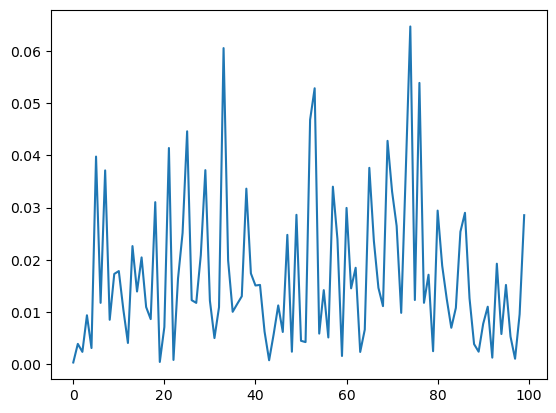

In [21]:
plt.plot(np.abs(lr.coef_.ravel()))